# How do residual shortcuts affect image-to-image mapping in a minimal setting?

The theory behind residual shortcuts, described in the original [ResNet paper](https://arxiv.org/abs/1512.03385), suggests that they should improve image-to-image mapping. Specifically, if we provide an image as input to a convolutional network, and set the objective to output the input unchanged, then we expect a residual shortcut from input to output to improve performance. 

Here we test that assumption in a semi-minimal setting with a 2-layer convolutional network equivalent to the resnet block described in the original papers' CIFAR-10 experiment.

## Prelims

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

## Data loader

We use the cell membrane dataset used in the [U-net paper](https://arxiv.org/abs/1505.04597), a set of 30 black and white microscopic images of cells.

In [11]:
train_pth = 'data/train/target'

In [12]:
class DataGen():
    """
    Open images from disk an format as numpy array 
    as expected by PyTorch DataLoader
    """
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        
    def __len__(self):
        return len(os.listdir(self.root_dir))
    
    def __getitem__(self, idx):
        filepath = f'{self.root_dir}/{idx}.png'
        img = Image.open(filepath)
        # binary black and white image 0=>black, 1=>white
        arr = np.asarray(img, dtype=np.float32) / 255
        return np.expand_dims(arr, axis=0)
        

In [13]:
# Initilise dataloader
dataset = DataGen(train_pth)
loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

The images in this dataset are binary black and white, which means that each pixel is either totally black `0.0` or totally white `1.0`. This means that an L1 loss will be an ideal objective, whereas if possible values were continuous then the L1 objective alone would encourage blurring.

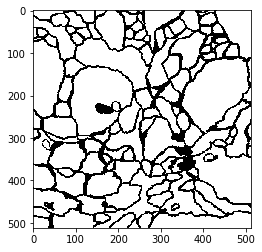

In [14]:
# Plot a sample image from the dataset
x = dataset[0]
plt.imshow(x[0], cmap='gray');

In [15]:
np.unique(x)

array([0., 1.], dtype=float32)

## Model

Setup PyTorch model and utility functions.

In [16]:
class resnet_block(nn.Module):
    
    """
    The ResNet block as described in the CIFAR-10 experiment of: 
    Deep Residual Learning for Image Recognition
    """
    def __init__(self, channels):
        super().__init__()
        
        # Setup layers
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(channels, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(channels, track_running_stats=True)
        self.relu2 = nn.ReLU()

        # Initialise weights 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)   
              
    
    def forward(self, x, shortcuts=False):
        # Forward pass
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        
        # Shortcut connection
        if shortcuts:
            z = z + x

        z = self.relu2(z)
        
        return z


In [17]:
def tensor2arr(tensor):
    """Convert torch tensor to numpy array"""
    arr = tensor.detach().numpy()
    return arr

def row_show(img_ts: list, titles: list):
    """Plot list of image tensors in a row with title"""
    cols = len(img_ts)
    fig, axs = plt.subplots(1, cols, figsize=(10, 3))
    for i, ax in enumerate(axs):
        ax.imshow(tensor2arr(img_ts[i][0, 0]), cmap='gray')
        ax.axis('off')
        ax.set_title(titles[i])
    plt.show()

We can now train two distinct models in parallel to test our hypothesis. For each step we train a model without and with a residual shortcut. After each epoch of training we record the average training loss and generate a sample image from each model to evaluate progress.

Epoch 0


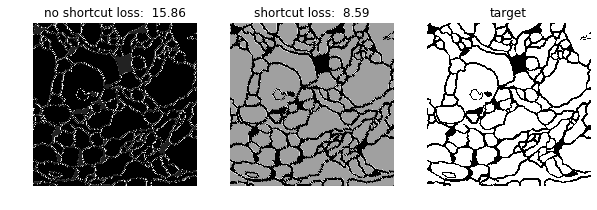

Epoch 1


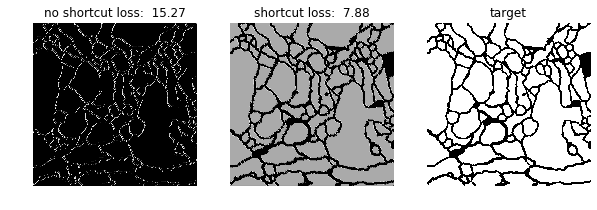

Epoch 2


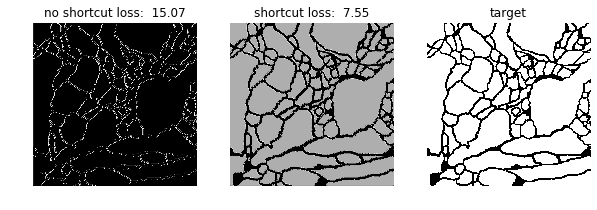

Epoch 3


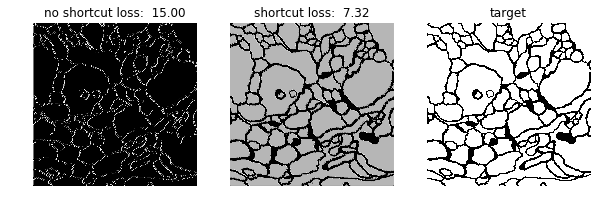

Epoch 4


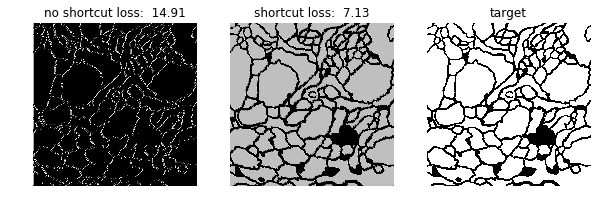

Epoch 5


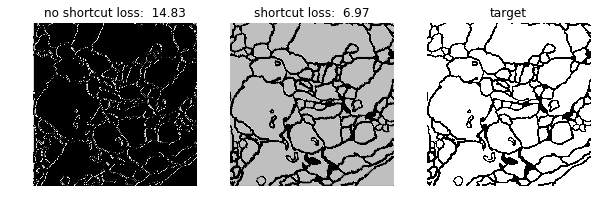

Epoch 6


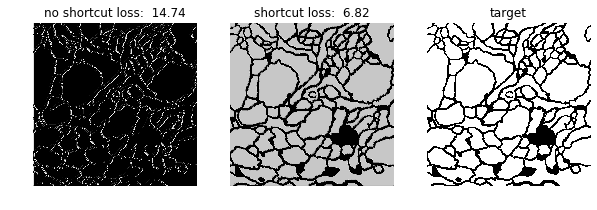

Epoch 7


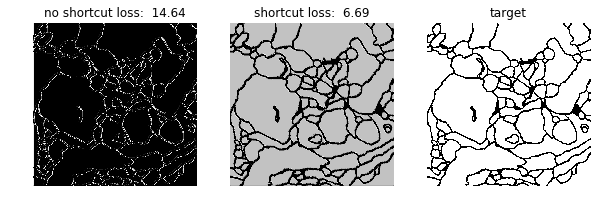

Epoch 8


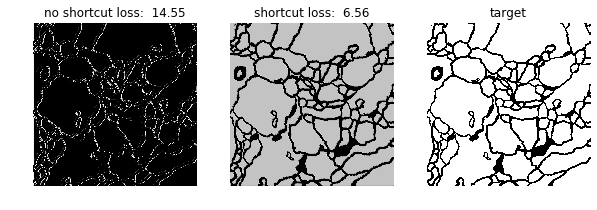

Epoch 9


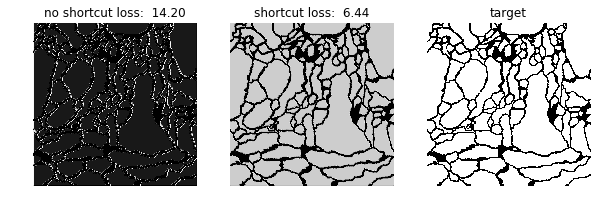

Epoch 10


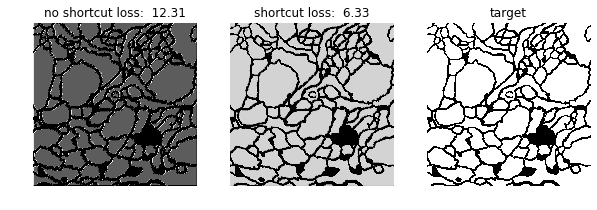

Epoch 11


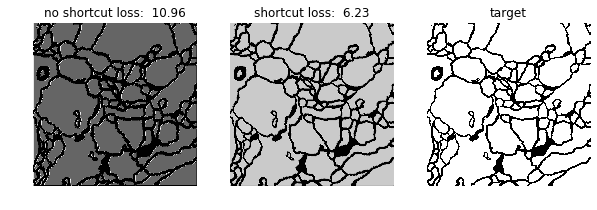

Epoch 12


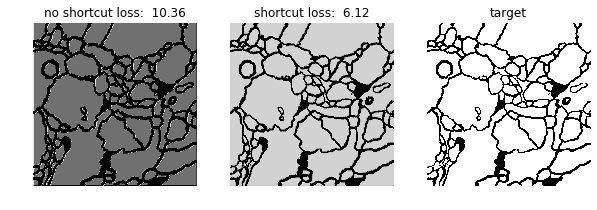

Epoch 13


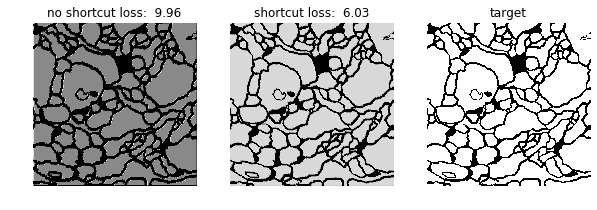

Epoch 14


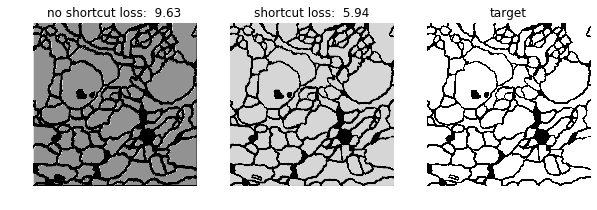

Epoch 15


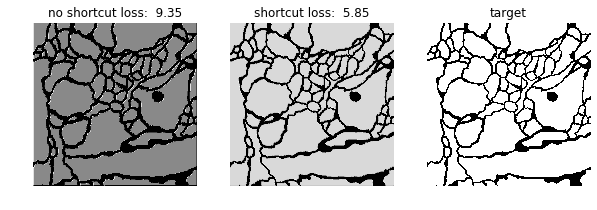

Epoch 16


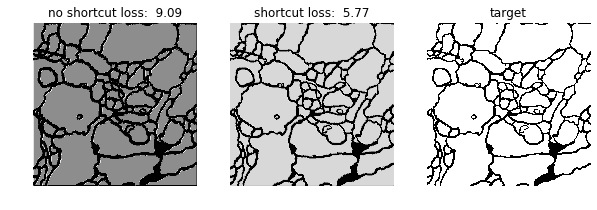

Epoch 17


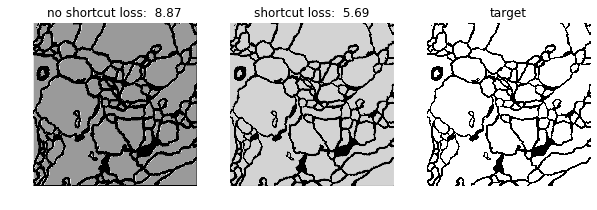

Epoch 18


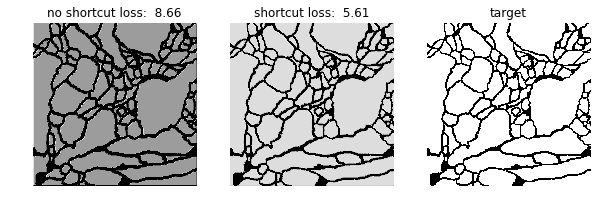

Epoch 19


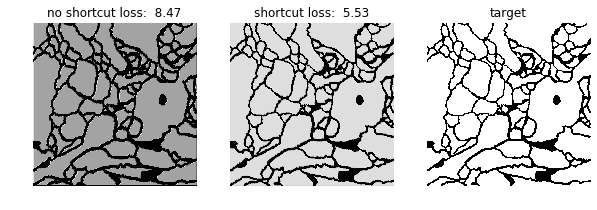

Epoch 20


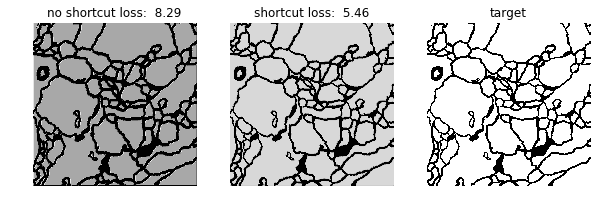

Epoch 21


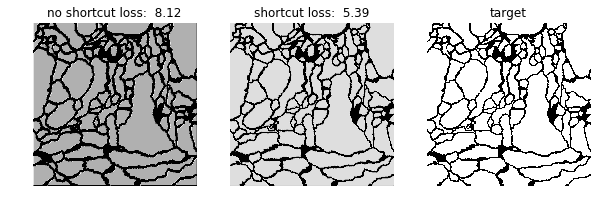

Epoch 22


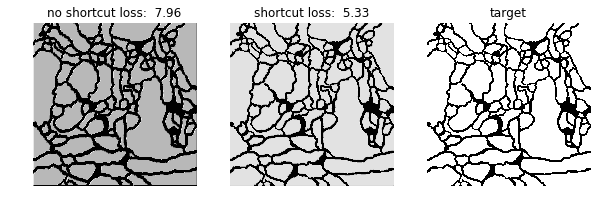

Epoch 23


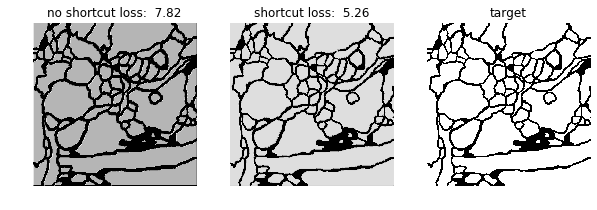

Epoch 24


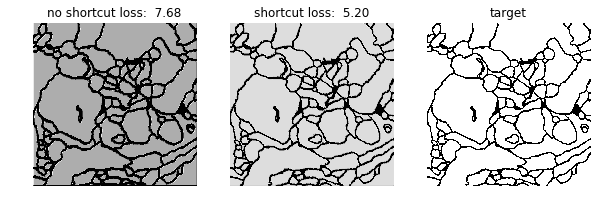

Epoch 25


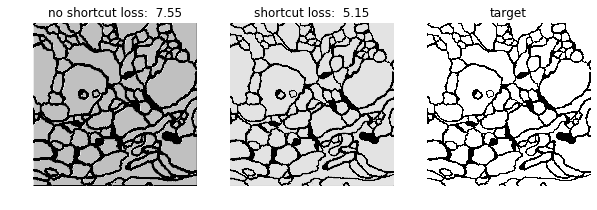

Epoch 26


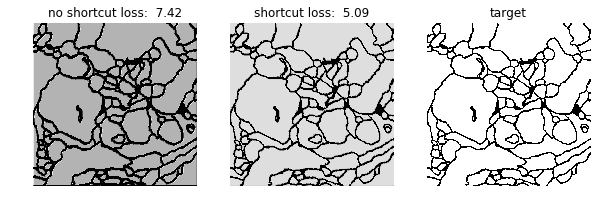

Epoch 27


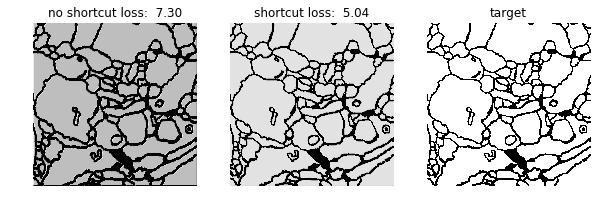

Epoch 28


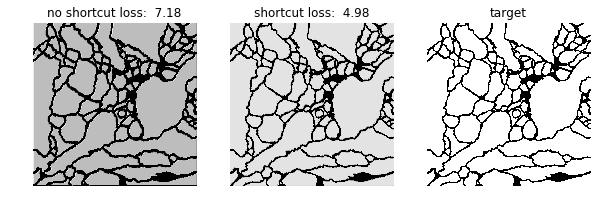

Epoch 29


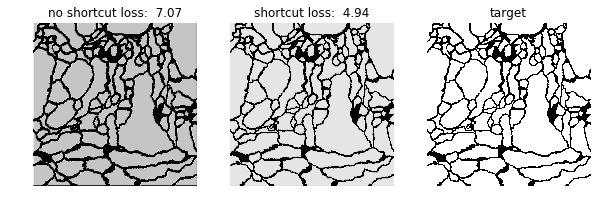

Epoch 30


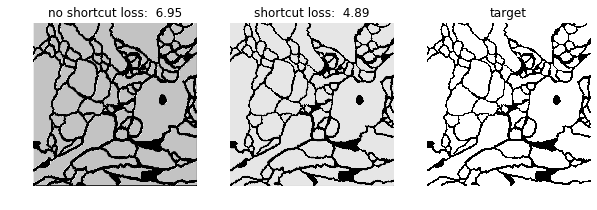

Epoch 31


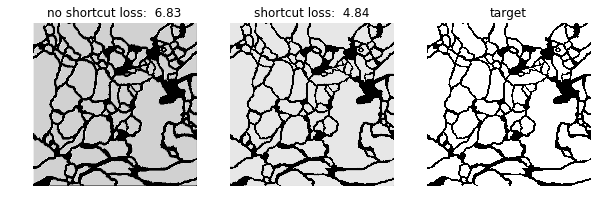

Epoch 32


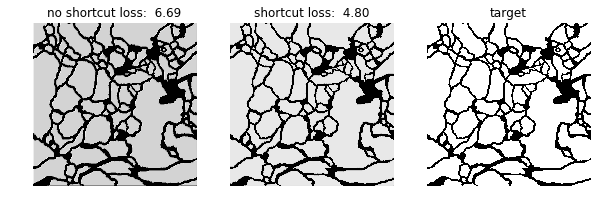

Epoch 33


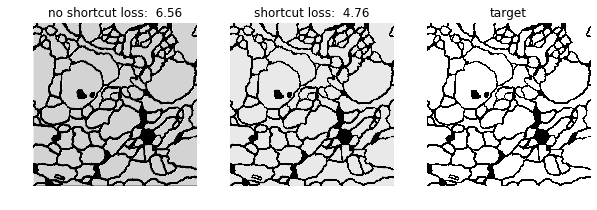

Epoch 34


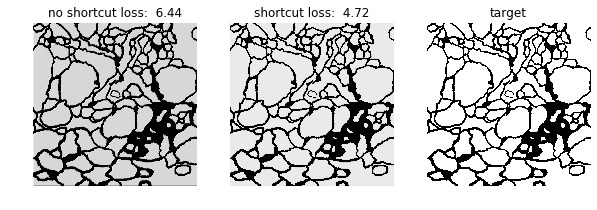

Epoch 35


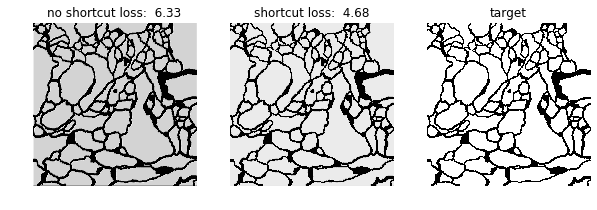

Epoch 36


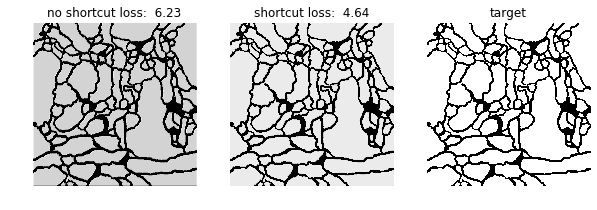

Epoch 37


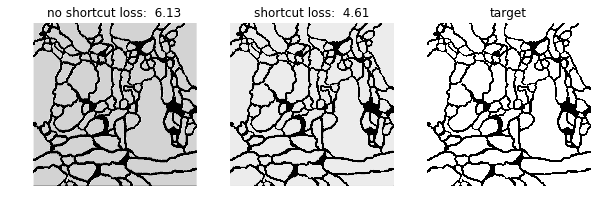

Epoch 38


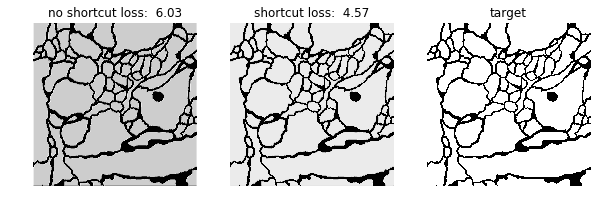

Epoch 39


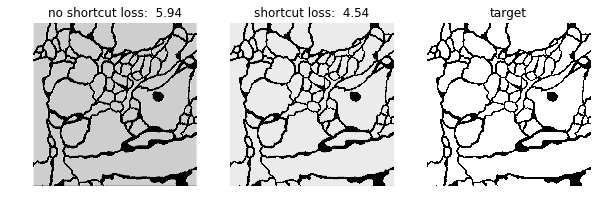

Epoch 40


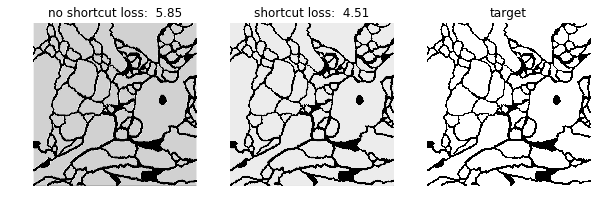

Epoch 41


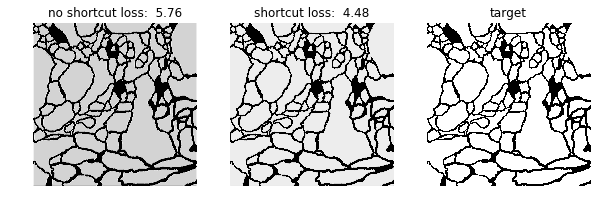

Epoch 42


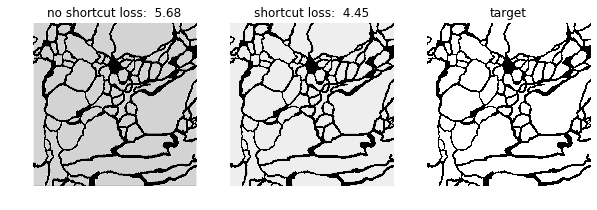

Epoch 43


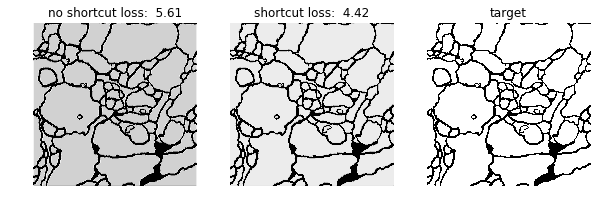

Epoch 44


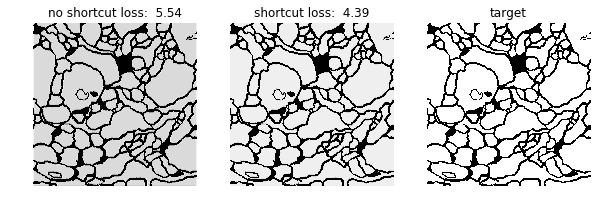

Epoch 45


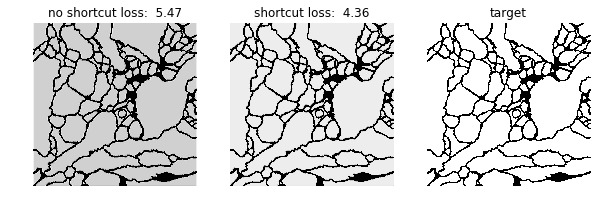

Epoch 46


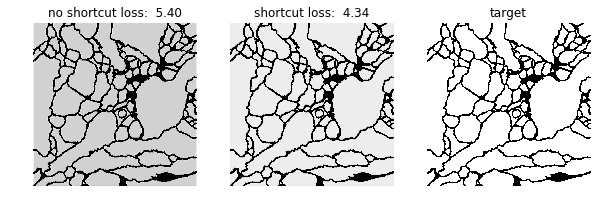

Epoch 47


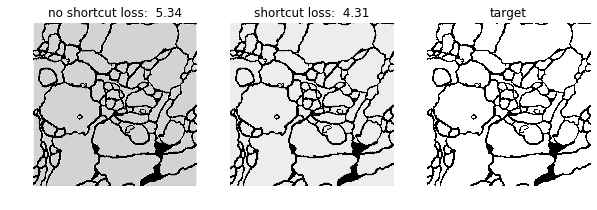

Epoch 48


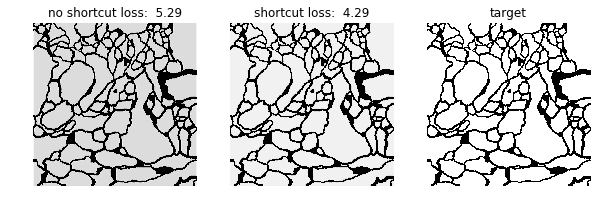

Epoch 49


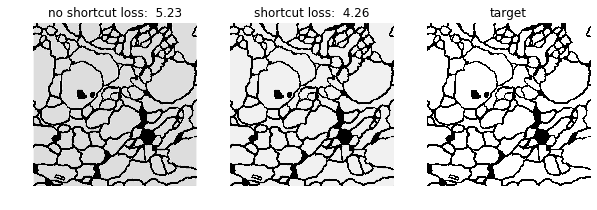

In [19]:
# Initialise two models, one to train with shortcut
# one to train without
shortcut_model = resnet_block(1)
s_optimizer = torch.optim.Adam(shortcut_model.parameters())
noshortcut_model = resnet_block(1)
ns_optimizer = torch.optim.Adam(noshortcut_model.parameters())

# Both models trained with L1 criterion
criterion = nn.L1Loss()

results = {'no_shortcut': [], 'shortcut': []}
for epoch in range(50):
    # mean loss for this epoch
    ns_loss = 0.0
    s_loss = 0.0
    
    for i, x in enumerate(loader, 0):
        
        # Train a net without shortcut
        ns_optimizer.zero_grad()
        z = torch.sigmoid(noshortcut_model(x, shortcuts=False))
        loss = criterion(z, x)
        loss.backward()
        ns_optimizer.step()
        ns_loss += loss.item()
        
        # Train a net with shortcut
        s_optimizer.zero_grad()
        z = torch.sigmoid(shortcut_model(x, shortcuts=True))
        loss = criterion(z, x)
        loss.backward()
        s_optimizer.step()
        s_loss += loss.item()
              
    # Record results
    results['no_shortcut'].append(ns_loss)
    results['shortcut'].append(s_loss)
    
    # Evaluate
    # Forward pass through each model
    ns_img = torch.sigmoid(noshortcut_model(x, shortcuts=False))
    s_img = torch.sigmoid(shortcut_model(x, shortcuts=True))
    # Plot results
    print(f'Epoch {epoch}')
    row_show([ns_img, s_img, x], 
             [f'no shortcut loss: {ns_loss : .2f}', 
              f'shortcut loss: {s_loss: .2f}', 
              'target'])
    

Let's plot the results:

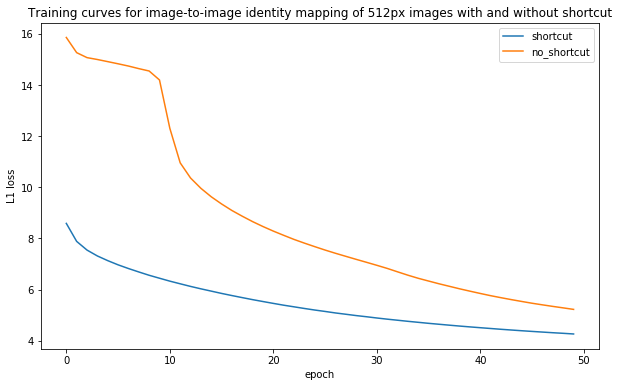

In [21]:
df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(list(df.index), df['shortcut'])
plt.plot(list(df.index), df['no_shortcut'])
plt.ylabel('L1 loss')
plt.xlabel('epoch')
plt.title('Training curves for image-to-image identity mapping of 512px images with and without shortcut')
plt.legend();

The model with residual shortcut learns significantly faster and after 50 epochs outperforms the model-without-shortcut.